# Understanding Met Office Data
[Met Office Site](https://www.metoffice.gov.uk/)

In [1]:
# Import the following packages
import os
import subprocess
from IPython.display import Image
from botocore import UNSIGNED
from botocore.config import Config
import requests
import xarray as xr
import pandas as pd
import numpy as np
import pyproj
import cfgrib
import pygrib
import zarr
import zipfile
import fsspec
import matplotlib.pyplot as plt

In [2]:
# Utility function to get the absolute path to a resource
def get_resource_path(relative_path):
    """Get absolute path to resource"""
    notebook_dir = os.getcwd()  # current working directory of the notebook
    return os.path.join(notebook_dir, 'resources', relative_path)

### Terminology:
- NWP (Numerical Weather Prediction). The use of mathematical models to simulate atmospheric processes and predict future weather conditions.
- The Unified Model (UM) is a numerical model of the atmosphere used for both weather and climate applications.
  - [Unified Model Documentation](https://www.metoffice.gov.uk/research/approach/modelling-systems/unified-model/weather-forecasting)

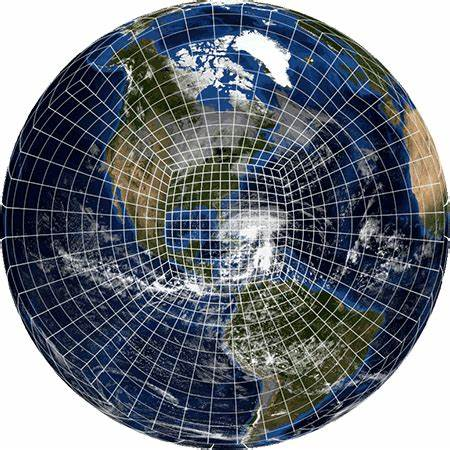

In [3]:
image_path = get_resource_path('images/gfs_grid.jpeg')
Image(filename=image_path, width=300)

# Understanding Coordinates in the UKV Dataset 🌍

## Latitude and Longitude Basics
- **Latitude**: Runs horizontally, measuring north-south position.
  - 0° is the Equator, +90° is the North Pole, -90° is the South Pole.
  - For the UK, latitudes range from ~49°N (southern UK) to ~61°N (northern Scotland).
- **Longitude**: Runs vertically, measuring east-west position.
  - 0° is the Prime Meridian (Greenwich, England).
  - The UK spans ~8°W (west, e.g., western Ireland) to ~2°E (east, e.g., eastern England).
  - Longitudes use the -180° to +180° convention (e.g., -8° for 8°W, +2° for 2°E).

## UKV Dataset Coordinates
- The UKV model data uses a **Lambert Azimuthal Equal Area** projection, with:
  - **X-Coordinates**: East-west positions in meters (-1,158,000 m to 924,000 m, 1,042 points, 2km resolution).
  - **Y-Coordinates**: North-south positions in meters (-1,036,000 m to 902,000 m, 970 points, 2km resolution).
- These form a 970 x 1,042 grid covering the UK and surrounding areas.
- We convert these to latitude/longitude for easier interpretation using the `pyproj` library, based on:
  - Projection origin: 52°N, -2°E (center of the UK).
  - WGS84 ellipsoid (Earth’s shape parameters).

## Why This Matters for Solar Forecasting
- The `surface_downwelling_shortwave_flux_in_air` data is mapped to this grid, showing solar radiation (W/m²) at each point.
- Latitude/longitude coordinates help us:
  - Locate specific sites (e.g., solar farms) on the grid.
  - Align radiation data with other datasets or observations.
- Example: A solar farm at 51.5°N, -0.1°E (near London) can be mapped to the nearest grid point for forecasting.

## Longitude Convention
- Longitudes are output in the **-180° to +180°** range (e.g., -8° to +2° for the UK), following CF-1.7 conventions.
- If needed, we can convert to 0° to 360° (e.g., 8°W becomes 352°E) by adding 360° to negative longitudes.

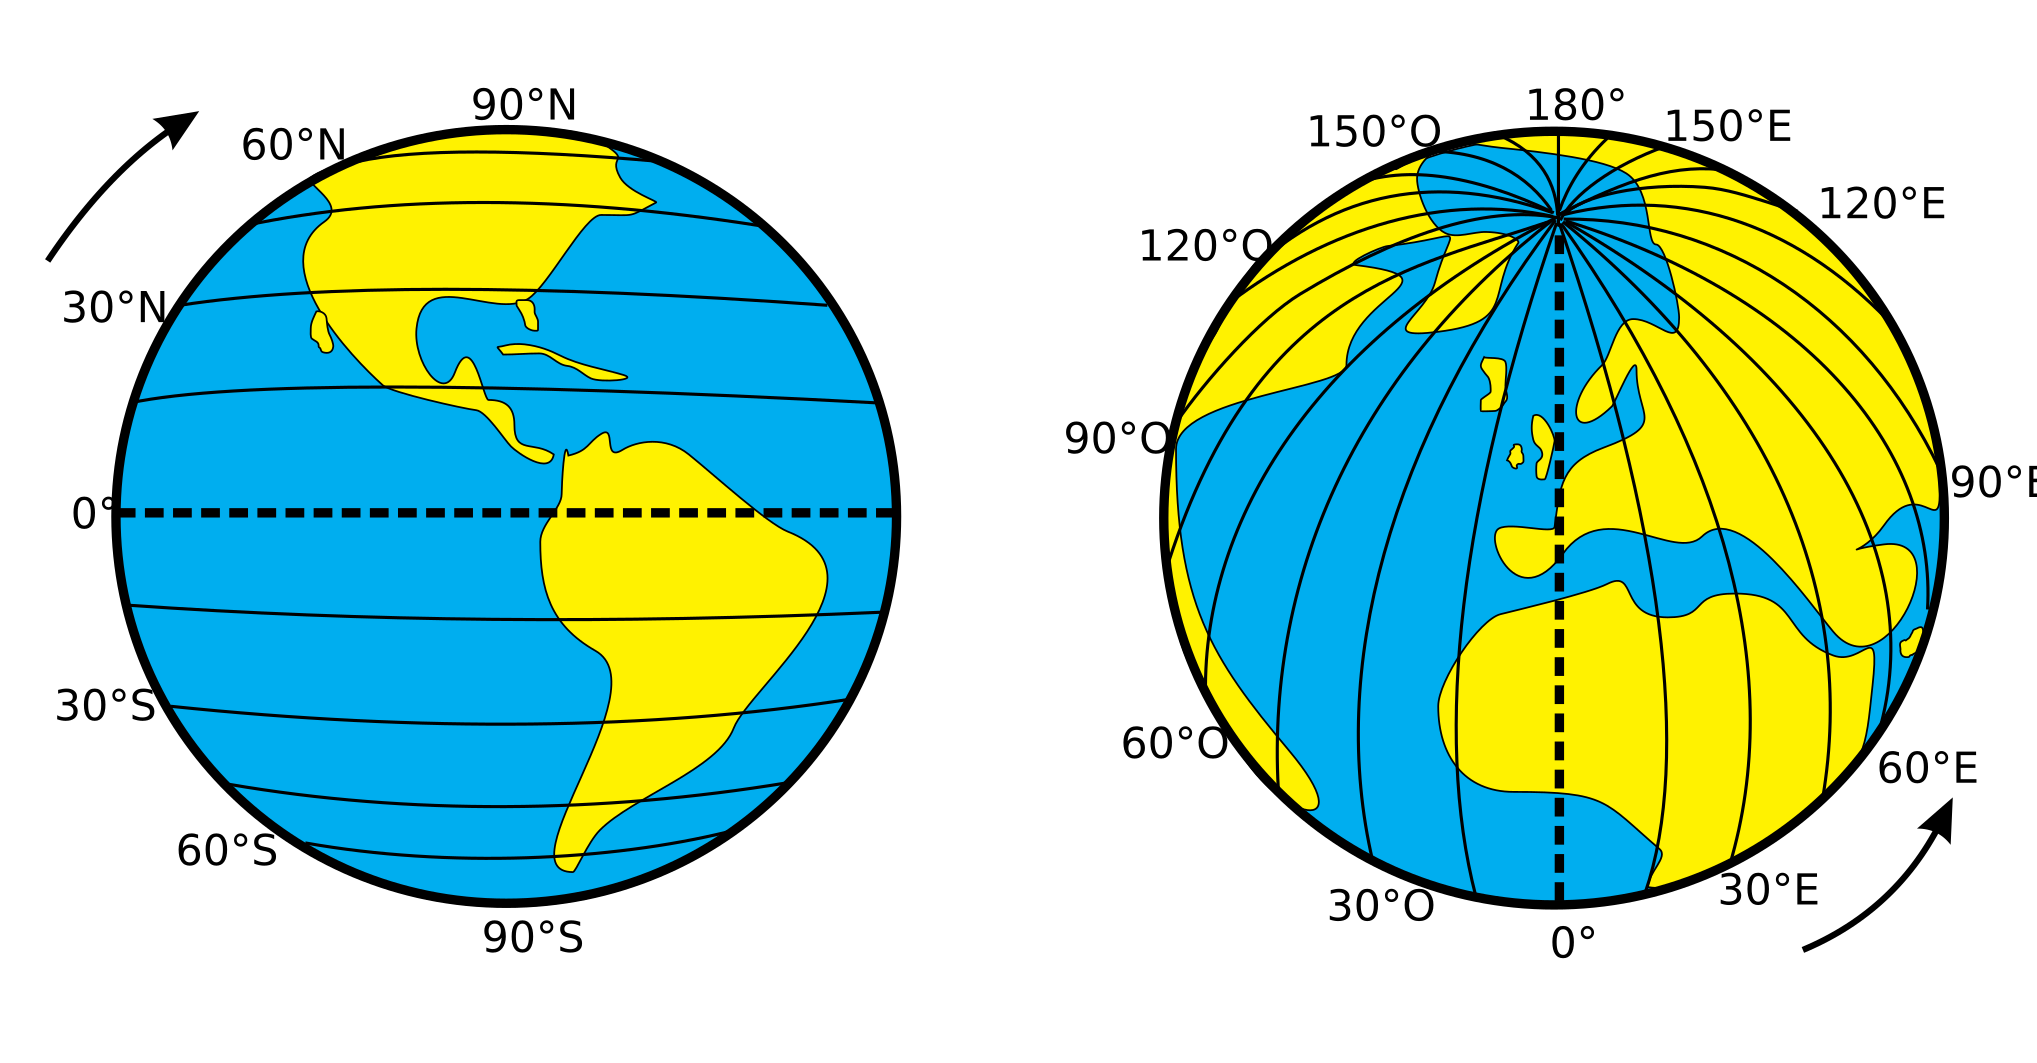

In [3]:
# Source: https://upload.wikimedia.org/wikipedia/commons/8/86/Latitude_and_Longitude_of_the_Earth_fr.svg
image_path = get_resource_path('images/Latitude_and_Longitude_of_the_Earth.png')
Image(filename=image_path, width=400)

### You can access the Met Office data on AWS Registry of Open Data
The flagship Numerical Weather Prediction model developed and used at the Met Office, is the Unified Model, the same model is used for both weather and climate prediction. For weather forecasting the Met Office runs several configurations of the Unified Model as part of its operational Numerical Weather Prediction suite. Uncovering 2 years' worth of historical data, updated regularly with a time delay. The UK deterministic model is a post processed regional downscaled configuration of the Unified Model, covering the UK and Ireland, with a resolution of approximately 0.018 degrees. The United Kingdom domain is a 1,096km x 1,408km (2km resolution grid). Formatted via NetCDF. Please note this is a public beta and therefore a non-operational service.

[AWS Open Data Link](https://registry.opendata.aws/met-office-uk-deterministic/)

In [5]:
# To see the first 14 (head) stdout of the s3 bucket
# Met Office data on AWS Registry is 2-year rolling archive, so it will change over time depending on when you run the command line
!aws s3 ls --no-sign-request s3://met-office-atmospheric-model-data/uk-deterministic-2km/ 2>/dev/null | head -n 14

                           PRE 20230601T0000Z/
                           PRE 20230601T0100Z/
                           PRE 20230601T0200Z/
                           PRE 20230601T0300Z/
                           PRE 20230601T0400Z/
                           PRE 20230601T0500Z/
                           PRE 20230601T0600Z/
                           PRE 20230601T0700Z/
                           PRE 20230601T0800Z/
                           PRE 20230601T0900Z/
                           PRE 20230601T1000Z/
                           PRE 20230601T1100Z/
                           PRE 20230601T1200Z/
                           PRE 20230601T1300Z/


In [7]:
# The following code gets the time_period we can use in our notebook. The Metoffice data is a rolling 2 year period so this
# allows us to get a dynamic period as opposed to hard coding one that will fail after a month
# Run the aws s3 ls command and capture the output, first 14 lines and grep T1200Z
command = "aws s3 ls --no-sign-request s3://met-office-atmospheric-model-data/uk-deterministic-2km/ 2>/dev/null | head -n 14 | grep T1200Z"
result = subprocess.check_output(command, shell=True, text=True)

# Split the output into lines and get the last line (most recent timestamp)
lines = result.strip().split('\n')
last_line = lines[-1]
time_period = last_line.split()[-1].strip('/').replace('PRE ', '')
print(f"time_period assigned to {time_period}")

time_period assigned to 20230601T1200Z


In [8]:
# This data is stored as .nc (NetCDF) format files
# We will look at just the first 50 channels, remove the `head -n 50` arg if you want to see more
s3_path = f"s3://met-office-atmospheric-model-data/uk-deterministic-2km/{time_period}/"
# Run the aws s3 ls command to list .nc files, limiting to 50 lines
command = f"aws s3 ls --no-sign-request {s3_path} 2>/dev/null | head -n 50"
result = subprocess.check_output(command, shell=True, text=True)
print(result)

2024-01-27 01:19:40     856764 20230601T1200Z-PT0000H00M-CAPE_most_unstable_below_500hPa.nc
2024-01-27 00:36:48     843210 20230601T1200Z-PT0000H00M-CAPE_surface.nc
2024-01-26 23:16:24     574723 20230601T1200Z-PT0000H00M-cloud_amount_below_1000ft_ASL.nc
2024-01-26 23:22:41     306212 20230601T1200Z-PT0000H00M-cloud_amount_of_high_cloud.nc
2024-01-26 23:25:56     787976 20230601T1200Z-PT0000H00M-cloud_amount_of_low_cloud.nc
2024-01-26 23:27:10     199477 20230601T1200Z-PT0000H00M-cloud_amount_of_medium_cloud.nc
2024-01-26 23:26:19     843586 20230601T1200Z-PT0000H00M-cloud_amount_of_total_cloud.nc
2024-01-27 01:11:05    8447029 20230601T1200Z-PT0000H00M-cloud_amount_on_height_levels.nc
2024-01-26 23:00:36      89741 20230601T1200Z-PT0000H00M-fog_fraction_at_screen_level.nc
2024-01-27 00:21:46      76644 20230601T1200Z-PT0000H00M-hail_fall_rate.nc
2024-01-27 00:30:10     472945 20230601T1200Z-PT0000H00M-height_AGL_at_cloud_base_where_cloud_cover_2p5_oktas.nc
2024-01-27 01:17:56    14371

In [9]:
# Let's look at the most relevant channel for solar forecasting: `radiation_flux_in_shortwave_total_downward_at_surface`
command = f"aws s3 ls --no-sign-request {s3_path} 2>/dev/null | head -n 50 | grep radiation_flux_in_shortwave_total_downward_at_surface"
result = subprocess.check_output(command, shell=True, text=True)
lines = result.strip().split('\n')
shortwave_total_downward_file_name = lines[0].split()[-1]
cp_command = f"aws s3 cp --no-sign-request {s3_path}{shortwave_total_downward_file_name} ."
try:
    subprocess.run(cp_command, shell=True, check=True)
    print(f"Successfully downloaded {shortwave_total_downward_file_name}")
except subprocess.CalledProcessError as e:
    print(f"Failed to download {file_name}: {e}")
# Below comment is an example of what the command would look like if you just ran it without subprocess    
#!aws s3 cp --no-sign-request s3://met-office-atmospheric-model-data/uk-deterministic-2km/20230501T1200Z/20230501T1200Z-PT0000H00M-radiation_flux_in_shortwave_total_downward_at_surface.nc .

download: s3://met-office-atmospheric-model-data/uk-deterministic-2km/20230601T1200Z/20230601T1200Z-PT0000H00M-radiation_flux_in_shortwave_total_downward_at_surface.nc to ./20230601T1200Z-PT0000H00M-radiation_flux_in_shortwave_total_downward_at_surface.nc
Successfully downloaded 20230601T1200Z-PT0000H00M-radiation_flux_in_shortwave_total_downward_at_surface.nc


In [13]:
# Load the NetCDF file
ds = xr.open_dataset(shortwave_total_downward_file_name)

# Print the dataset summary
print(ds)

# Inspect specific details
print("\nVariables:")
print(ds.data_vars)  # Lists data variables (e.g., radiation flux)
print("\nCoordinates:")
print(ds.coords)  # Lists dimensions (e.g., latitude, longitude, time)
print("\nAttributes:")
print(ds.attrs)  # Lists metadata (e.g., units, description)

# Access the main variable (e.g., shortwave radiation)
main_variable = list(ds.data_vars.keys())[0]  # Assumes the first variable is the main one
print(f"\nMain variable details ({main_variable}):")
print(ds[main_variable])

<xarray.Dataset> Size: 4MB
Dimensions:                                    (projection_y_coordinate: 970,
                                                projection_x_coordinate: 1042,
                                                bnds: 2)
Coordinates:
  * projection_y_coordinate                    (projection_y_coordinate) float32 4kB ...
  * projection_x_coordinate                    (projection_x_coordinate) float32 4kB ...
    forecast_period                            timedelta64[ns] 8B ...
    forecast_reference_time                    datetime64[ns] 8B ...
    time                                       datetime64[ns] 8B ...
Dimensions without coordinates: bnds
Data variables:
    surface_downwelling_shortwave_flux_in_air  (projection_y_coordinate, projection_x_coordinate) float32 4MB ...
    lambert_azimuthal_equal_area               int32 4B ...
    projection_y_coordinate_bnds               (projection_y_coordinate, bnds) float32 8kB ...
    projection_x_coordinate_bnds      

In [14]:
# Print y-coordinate details
y_coords = ds['projection_y_coordinate'].values
print("Y Coordinates (first 5, last 5):", y_coords[:5], y_coords[-5:])
print("Number of Y points:", len(y_coords))
print("Min Y:", y_coords.min())
print("Max Y:", y_coords.max())
print("Spacing (assuming uniform):", y_coords[1] - y_coords[0])

Y Coordinates (first 5, last 5): [-1036000. -1034000. -1032000. -1030000. -1028000.] [894000. 896000. 898000. 900000. 902000.]
Number of Y points: 970
Min Y: -1036000.0
Max Y: 902000.0
Spacing (assuming uniform): 2000.0


In [15]:
# Print y-coordinate details
x_coords = ds['projection_x_coordinate'].values
print("X Coordinates (first 5, last 5):", x_coords[:5], x_coords[-5:])
print("Number of X points:", len(x_coords))
print("Min X:", x_coords.min())
print("Max X:", x_coords.max())
print("Spacing (assuming uniform):", x_coords[1] - x_coords[0])

X Coordinates (first 5, last 5): [-1158000. -1156000. -1154000. -1152000. -1150000.] [916000. 918000. 920000. 922000. 924000.]
Number of X points: 1042
Min X: -1158000.0
Max X: 924000.0
Spacing (assuming uniform): 2000.0


------
### Projection Parameters
The data uses a **Lambert Azimuthal Equal Area** projection, defined by:
- **Latitude of Origin**: 52.0°N (center of the UK grid).
- **Longitude of Origin**: -2.0°E (center of the UK grid).
- **Ellipsoid**: WGS84 (semi-major axis: 6,378,137 m; semi-minor axis: 6,356,752.314245 m).
These parameters are used to convert the grid coordinates (x, y in meters) to latitude/longitude for easier interpretation.

In [16]:
# Get projection details
grid_mapping = ds['surface_downwelling_shortwave_flux_in_air'].attrs['grid_mapping']
proj_attrs = ds[grid_mapping].attrs

# Define Lambert Azimuthal Equal Area projection
proj = pyproj.Proj(
    proj='laea',
    lat_0=proj_attrs.get('latitude_of_projection_origin', 52.0),
    lon_0=proj_attrs.get('longitude_of_projection_origin', -2.0),
    a=proj_attrs.get('semi_major_axis', 6378137.0),
    b=proj_attrs.get('semi_minor_axis', 6356752.314245)
)

# Get x and y coordinates
x_coords = ds['projection_x_coordinate'].values
y_coords = ds['projection_y_coordinate'].values
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Convert to lat/lon
lon, lat = proj(x_grid, y_grid, inverse=True)

# Add lat/lon to dataset
ds['latitude'] = (('projection_y_coordinate', 'projection_x_coordinate'), lat)
ds['longitude'] = (('projection_y_coordinate', 'projection_x_coordinate'), lon)

# Print sample lat/lon
print("Sample Latitudes (first 5, first column):", ds['latitude'].values[:5, 0])
print("Sample Longitudes (first 5, first column):", ds['longitude'].values[:5, 0])

Sample Latitudes (first 5, first column): [44.51715281 44.53481635 44.55247928 44.57014159 44.58780328]
Sample Longitudes (first 5, first column): [-17.11712928 -17.12183403 -17.12654262 -17.13125506 -17.13597135]


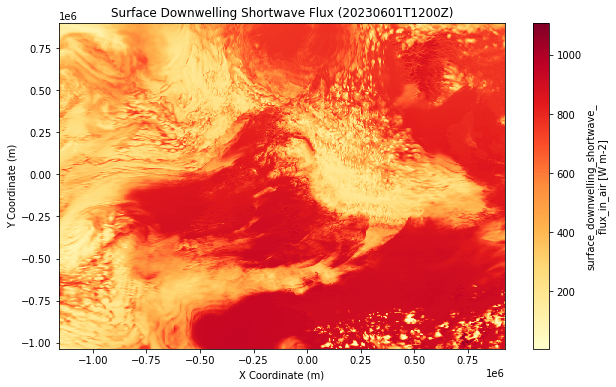

In [17]:
# Plot shortwave radiation
ds['surface_downwelling_shortwave_flux_in_air'].plot(cmap='YlOrRd', figsize=(10, 6))
plt.title(f'Surface Downwelling Shortwave Flux ({time_period})')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.show()

In [4]:
# Download Jan 2023 Metoffice data from OCF Hugging Face Dataset, change year, month and zarr zip file for
# other time periods
# Hugging Face OCF Metoffice Dataset: https://huggingface.co/datasets/openclimatefix/met-office-uk-deterministic-solar/tree/main/data
base_url = "https://huggingface.co/datasets/openclimatefix/met-office-uk-deterministic-solar/resolve/main/data"
year = "2023"
month = "01"
zarr_zip_file = "2023-01.zarr.zip"
url = f"{base_url}/{year}/{month}/monthly/{zarr_zip_file}"

# Download the file
response = requests.get(url)
with open(zarr_zip_file, "wb") as f:
    f.write(response.content)
print(f"Downloaded file: {zarr_zip_file}")

Downloaded file to: 2023-01.zarr.zip


In [3]:
#Unzip the zarr file:
zarr_zip_file = "2023-01.zarr.zip"
extracted_dir = "./data/2023-01_zarr"
os.makedirs(extracted_dir, exist_ok=True)
try:
    with zipfile.ZipFile(zarr_zip_file, "r") as zip_ref:
        zip_ref.extractall(extracted_dir)
    print(f"Extracted Zarr store to: {extracted_dir}")
except zipfile.BadZipFile as e:
    print(f"Error: The file {local_zip_path} is not a valid zip file: {e}")
    exit()
except Exception as e:
    print(f"Unexpected error while unzipping: {e}")
    exit()

Extracted Zarr store to: ./data/2023-01_zarr


In [2]:
# Step 2: Load the Zarr store with xarray
extracted_dir = "./data/2023-01_zarr"
zarr_path = extracted_dir  # Path to the extracted Zarr store directory
try:
    ds = xr.open_zarr(zarr_path)
    print("Dataset loaded successfully:")
    print(ds)
except Exception as e:
    print(f"Failed to load Zarr store: {e}")
    exit()

Dataset loaded successfully:
<xarray.Dataset> Size: 33GB
Dimensions:                                      (time: 743, step: 1,
                                                  projection_y_coordinate: 970,
                                                  projection_x_coordinate: 1042)
Coordinates:
    initialization_time                          (time) datetime64[ns] 6kB dask.array<chunksize=(24,), meta=np.ndarray>
  * projection_x_coordinate                      (projection_x_coordinate) float32 4kB ...
  * projection_y_coordinate                      (projection_y_coordinate) float32 4kB ...
  * step                                         (step) timedelta64[ns] 8B 00...
  * time                                         (time) datetime64[ns] 6kB 20...
Data variables:
    air_temperature                              (time, step, projection_y_coordinate, projection_x_coordinate) float32 3GB dask.array<chunksize=(24, 1, 243, 261), meta=np.ndarray>
    cloud_area_fraction               

In [3]:
# Step 3: Explore the dataset
print("Variables in the dataset:", list(ds.variables))
print("Time range:", ds["time"].values[[0, -1]])

Variables in the dataset: ['air_temperature', 'cloud_area_fraction', 'high_type_cloud_area_fraction', 'initialization_time', 'lambert_azimuthal_equal_area', 'low_type_cloud_area_fraction', 'lwe_thickness_of_surface_snow_amount', 'medium_type_cloud_area_fraction', 'projection_x_coordinate', 'projection_y_coordinate', 'step', 'surface_downwelling_longwave_flux_in_air', 'surface_downwelling_shortwave_flux_in_air', 'surface_downwelling_ultraviolet_flux_in_air', 'time', 'wind_from_direction', 'wind_speed']
Time range: ['2023-01-01T00:00:00.000000000' '2023-01-31T23:00:00.000000000']


## Variables in the Dataset:

- `air_temperature`: Temperature of the air.
- `cloud_area_fraction`: Total cloud cover fraction.
- `high_type_cloud_area_fraction`, `low_type_cloud_area_fraction`, `medium_type_cloud_area_fraction`: Fractions of high, low, and medium-level clouds, which are critical for solar forecasting as they affect irradiance.
- `initialization_time`: The time at which the forecast was initialized.
- `lambert_azimuthal_equal_area`: Metadata for the projection.
- `lwe_thickness_of_surface_snow_amount`: Liquid water equivalent thickness of snow on the surface, which can influence solar reflection.
- `projection_x_coordinate`, `projection_y_coordinate`: Spatial coordinates in the Lambert Azimuthal Equal Area projection.
- `step`: Forecast step or lead time (e.g., hours ahead of initialization time).
- `surface_downwelling_longwave_flux_in_air`: Downwelling longwave radiation at the surface.
- `surface_downwelling_shortwave_flux_in_air`: Downwelling shortwave radiation (solar flux), our key variable for solar forecasting.
- `surface_downwelling_ultraviolet_flux_in_air`: Downwelling ultraviolet radiation.
- `time`: The time dimension, covering the forecast valid times.
- `wind_from_direction`, `wind_speed`: Wind direction and speed, which can influence weather patterns affecting solar radiation.

In [4]:
# Inspect the shortwave flux variable
shortwave_flux = ds["surface_downwelling_shortwave_flux_in_air"]

In [5]:
# Get projection details
grid_mapping = ds["surface_downwelling_shortwave_flux_in_air"].attrs["grid_mapping"]
proj_attrs = ds[grid_mapping].attrs

# Define Lambert Azimuthal Equal Area projection
proj = pyproj.Proj(
    proj="laea",
    lat_0=proj_attrs.get("latitude_of_projection_origin", 52.0),
    lon_0=proj_attrs.get("longitude_of_projection_origin", -2.0),
    a=proj_attrs.get("semi_major_axis", 6378137.0),
    b=proj_attrs.get("semi_minor_axis", 6356752.314245),
)

# Get x and y coordinates
x_coords = ds["projection_x_coordinate"].values
y_coords = ds["projection_y_coordinate"].values
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Convert to lat/lon
lon, lat = proj(x_grid, y_grid, inverse=True)

# Add lat/lon to dataset
ds["latitude"] = (("projection_y_coordinate", "projection_x_coordinate"), lat)
ds["longitude"] = (("projection_y_coordinate", "projection_x_coordinate"), lon)

# Print sample lat/lon
print("Sample Latitudes (first 5, first column):", ds["latitude"].values[:5, 0])
print("Sample Longitudes (first 5, first column):", ds["longitude"].values[:5, 0])

Sample Latitudes (first 5, first column): [44.51715281 44.53481635 44.55247928 44.57014159 44.58780328]
Sample Longitudes (first 5, first column): [-17.11712928 -17.12183403 -17.12654262 -17.13125506 -17.13597135]


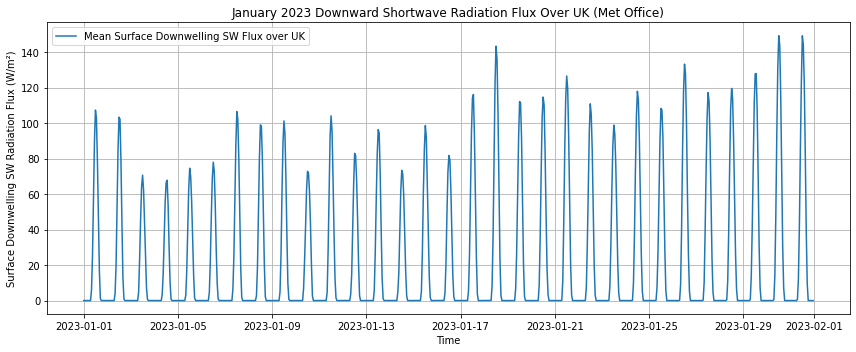

In [7]:
# Plot Downward Shortwave Radiation Flux Over UK in January
shortwave_flux_mean = ds['surface_downwelling_shortwave_flux_in_air'].mean(dim=["projection_y_coordinate", "projection_x_coordinate"])

# Extract time and values as flat arrays
forecast_time = shortwave_flux_mean['time'].values
shortwave_flux_flat = shortwave_flux_mean.values.flatten()

# Create a DataFrame
df = pd.DataFrame({
    "forecast_time": forecast_time,
    "shortwave_flux_flat": shortwave_flux_flat
})

# Sort by forecast_time and plot
df = df.sort_values("forecast_time")

plt.figure(figsize=(12, 5))
plt.plot(df["forecast_time"], df["shortwave_flux_flat"], label="Mean Surface Downwelling SW Flux over UK")
plt.xlabel("Time")
plt.ylabel("Surface Downwelling SW Radiation Flux (W/m²)")
plt.title("January 2023 Downward Shortwave Radiation Flux Over UK (Met Office)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

With these examples, you should have learned a bit about the GFS and NWP data as well as tools you can use for the OCF open-data-pvnet project. Now your turn to explore further the dataset...